In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = CIFAR10(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=2048, shuffle=True, num_workers=2)
testset = CIFAR10(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=2048, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
25 5


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 5, stride = 1, padding=2),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		)
        self.conv_block2 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 5, stride = 1, padding=2),
			nn.BatchNorm2d(channel_num),
		)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [4]:
class BasicTransBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicTransBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.ConvTranspose2d(channel_num, channel_num, 5, stride = 1, padding=2),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		)
        self.conv_block2 = nn.Sequential(
			nn.ConvTranspose2d(channel_num, channel_num, 5, stride = 1, padding=2),
			nn.BatchNorm2d(channel_num),
		)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [5]:
class Cifar10_ResNetAE(nn.Module):
    def __init__(self, in_channels = 3, type = 18):
        super(Cifar10_ResNetAE, self).__init__()
        self.struc_dict = {
            18: {
                "num_channels" : [48],
                "counts" : [1]
            }
        }
        channel_init = self.struc_dict[type]["num_channels"][0]
        self.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=channel_init, kernel_size=5, stride=3)
        torch.nn.init.kaiming_normal_(self.conv_in.weight)
        self.max_in = nn.MaxPool2d(2)

        num_channels = self.struc_dict[type]["num_channels"]
        counts = self.struc_dict[type]["counts"]
        inv_num_channels = self.struc_dict[type]["num_channels"][::-1]
        
        self.encoder = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                num_channels, 
                counts
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.encoder.add_module(f"conv{idx}_{i}", BasicBlock(num_channel))
            if idx < len(num_channels) - 1:
                self.encoder.add_module(
                    f"conv_switch{idx}_{idx+1}", nn.Conv2d(num_channel, num_channels[idx+1], 3, 1)
                )
                self.encoder.add_module(
                    f"bn{idx}_{idx+1}", nn.BatchNorm2d(num_channels[idx+1])
                )
        self.dw_latent = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(5 * 5 * 48, 256),
        )
        
        self.latent = nn.Linear(256, 256)
        
        self.up_latent = nn.Sequential(
            nn.Linear(128, 256),
            nn.Linear(256, 5 * 5 * 48),            
        )
        
        self.decoder = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                inv_num_channels, 
                counts
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.decoder.add_module(f"deconv{idx}_{i}", BasicTransBlock(num_channel))
            if idx < len(inv_num_channels) - 1:
                self.decoder.add_module(
                    f"deconv_switch{idx}_{idx+1}", nn.ConvTranspose2d(num_channel, inv_num_channels[idx+1], 3, 1)
                )
                self.decoder.add_module(
                    f"bn{idx}_{idx+1}", nn.BatchNorm2d(inv_num_channels[idx+1])
                )

        self.up_out = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_out = nn.ConvTranspose2d(in_channels=channel_init, out_channels=in_channels, kernel_size=5, stride=3)
        torch.nn.init.kaiming_normal_(self.conv_out.weight)
                                     
    def forward(self, x):
        x = self.conv_in(x)
        x = self.max_in(x)
        x = self.encoder(x)
        lat = self.latent(self.dw_latent(x))
        mu, lv = self.unwrap(lat)
        rec_lat = self.up_latent(self.reparam(mu, lv))
        x = self.decoder(rec_lat.view(-1, 48, 5, 5))
        x = self.up_out(x)
        x = self.conv_out(x)
        return x, mu, lv

    def unwrap(self, x):
        return torch.split(x, x.shape[1]//2, dim=1)

    def reparam(self, mu, lv):
        if self.training:
            std = torch.exp(0.5 * lv)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

In [6]:
def gaussian_kls(mu, logvar, mean=False):

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())

    if mean:
        reduce = lambda x: torch.mean(x, 1)
    else:
        reduce = lambda x: torch.sum(x, 1)

    total_kld = reduce(klds).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = reduce(klds).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

epochs = 10

model = Cifar10_ResNetAE().to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, epochs)

loss_fn = nn.MSELoss()

In [8]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss, _, _ = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch: 0 - TrainLoss: 12.755802173614502 - ValidLoss: 3.368290901184082


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch: 1 - TrainLoss: 2.084900002479553 - ValidLoss: 1.7897005558013916


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch: 2 - TrainLoss: 1.5434778642654419 - ValidLoss: 1.4228970766067506


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch: 3 - TrainLoss: 1.3429149675369263 - ValidLoss: 1.2672141313552856


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch: 4 - TrainLoss: 1.2196103143692016 - ValidLoss: 1.166214156150818


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch: 5 - TrainLoss: 1.1326360654830934 - ValidLoss: 1.0901909351348877


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch: 6 - TrainLoss: 1.063754153251648 - ValidLoss: 1.0308123588562013


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch: 7 - TrainLoss: 1.0094291043281556 - ValidLoss: 0.983064603805542


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch: 8 - TrainLoss: 0.9656068468093872 - ValidLoss: 0.9428723454475403


100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]

Epoch: 9 - TrainLoss: 0.9279379796981811 - ValidLoss: 0.9105692148208618


In [9]:
model.eval()
with torch.no_grad():
    va_total_loss = 0
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss += valid_loss.item()

print(f"ValidLoss: {va_total_loss/len(test_dl)}")

100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]

ValidLoss: 0.9105692148208618


  0%|                                                                 | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|█████████████████                                        | 3/10 [00:00<00:00, 27.52it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for i

tensor(422.0681, device='cuda:0')
tensor(-1408.3542, device='cuda:0')
tensor(-529.9402, device='cuda:0')
tensor(-1397.6477, device='cuda:0')
tensor(457.8608, device='cuda:0')
tensor(828.0090, device='cuda:0')
tensor(1697.8728, device='cuda:0')
tensor(1264.3838, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1589.4209, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 90%|███████████████████████████████████████████████████▎     | 9/10 [00:00<00:00, 42.27it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.07it/s]


tensor(-977.4560, device='cuda:0')


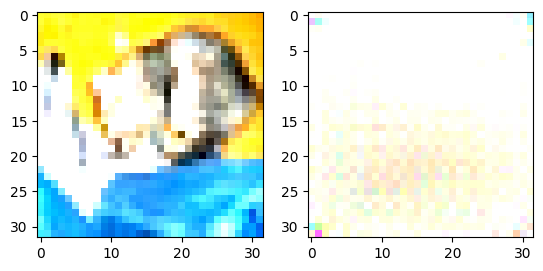

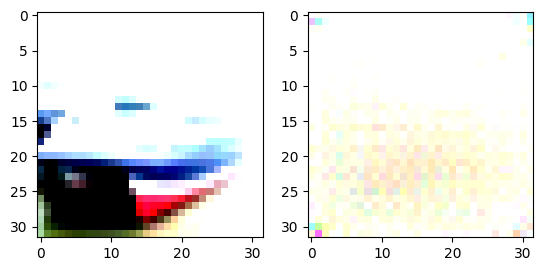

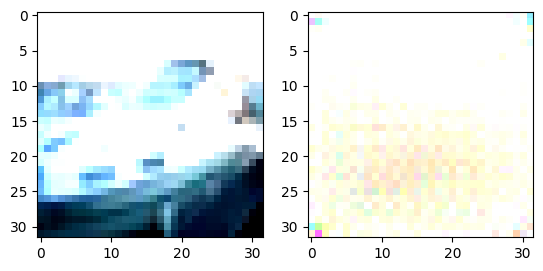

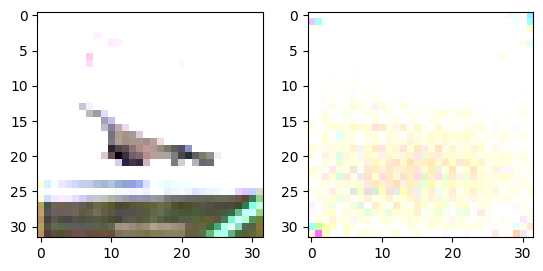

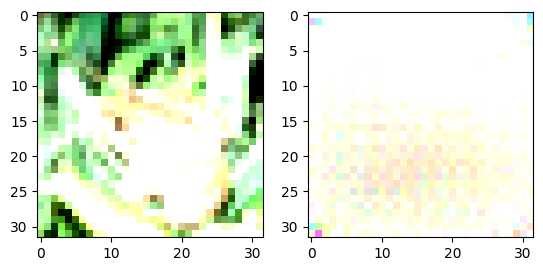

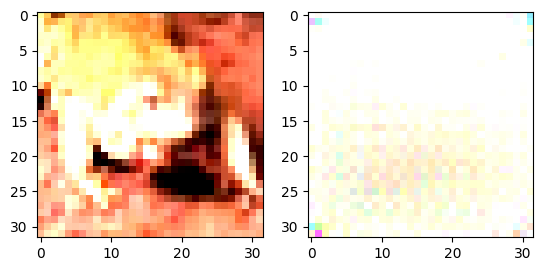

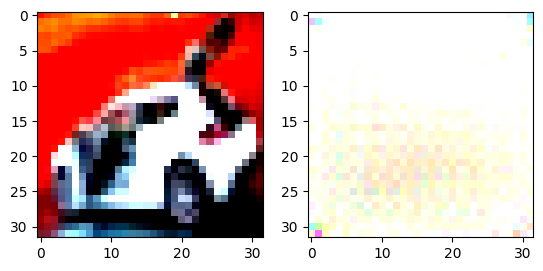

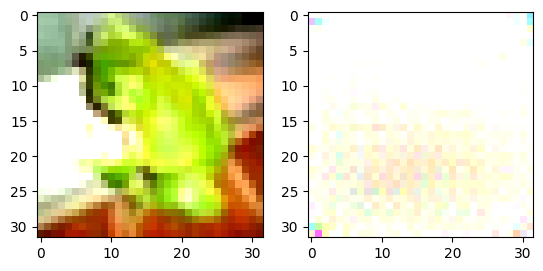

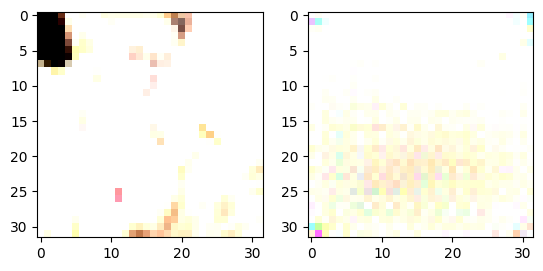

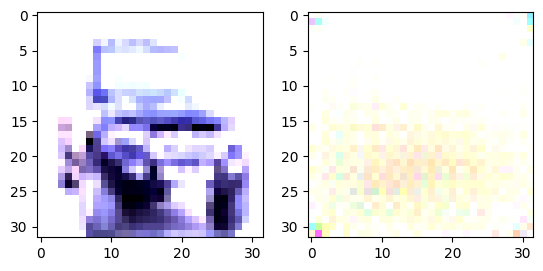

In [10]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)  
        print(torch.sum(gen_img - valid_img))

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())